# Optimal Control of a Distillation Column
------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------
## Problem Statement and Model
------------------------------------------------------------------------------------------------
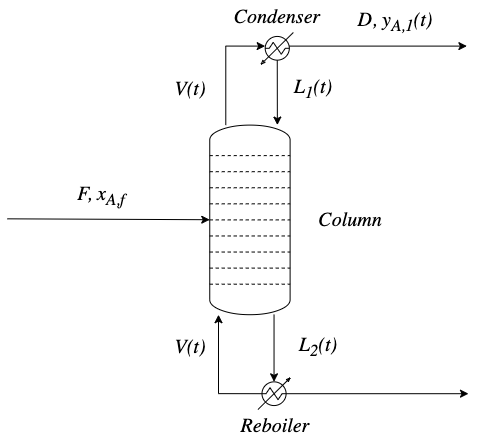

In this example, we will use `InfiniteOpt.jl` to model and optimize the control of a 30 tray ($NT$) distillation column, which is depicted in the figure above. The objective of our control policy will be to minimize the deviation between the distillate purity ($y_{A,1}(t)$) and the desired purity ($\bar{y}$). Along with this, we will add an economic consideration by minimizing the deviation of the reflux ratio ($u(t)$) from its final, steady-state value ($\bar{u}$). To simplify the analysis, the assumption of constant molal overflow will be implemented, creating constant flowrates between stages. Similarly, we will simplify equilibrium constraints within the column by assuming that the relative volatility ($\alpha_{A,B}$) of the two species is constant at each stage. With these assumptions, material and equilibrium constraints in the condenser, reboiler, feed stage, and the stripping and rectifying sections may be translated into a mathematical model for optimization as described below (Note: This problem was taken from https://www.sciencedirect.com/science/article/pii/S0098135418305210?casa_token=XajBcjWOnCYAAAAA:V0qeaxyj_9KIkeiMhTE0tEgtDqBALd2mdRMRiRvw9cqbvlrHpJVu5_9jvFMdg93lFROAV8dBWPQ)

$$
\begin{aligned}
\min_{u(t)} &&& \int_{0}^{65} \beta (y_{A,1}(t)-\bar{y})^2+(u(t)-\bar{u})^2 dt \\
\\
\text{s.t.} &&& \frac{d  x_{A, 1}(t) }{d t} = \frac{1}{A_{c}}V(t)(y_{A, 2}(t)-x_{A, 1}(t)), && \forall \ t \in [0,\ 65]\\
&&&  \frac{d  x_{A, i}(t) }{d t} = \frac{1}{A_{t}}(L_{1}(t)(x_{A, i-1}(t)-x_{A, i}(t))-V(t)(y_{A, i}(t)-y_{A, i+1}(t))), && \forall \  t \in [0, \ 65], \ i \in \{2, \dots, FT-1\}\\
&&&  \frac{d  x_{A, FT}(t) }{d t} = \frac{1}{A_{t}}(Fx_{A, f}+L_{1}(t)x_{A,FT-1}(t)-L_{2}(t)x_{A,FT}(t)-V(t)(y_{A, FT}(t)-y_{A, FT+1}(t))), && \forall \  t \in [0, \ 65] \\
&&&  \frac{d  x_{A, i}(t) }{d t} = \frac{1}{A_{t}}(L_{2}(t)(x_{A, i-1}(t)-x_{A, i}(t))-V(t)(y_{A, i}(t)-y_{A, i+1}(t))), && \forall \ t \in [0, \ 65], \ i \in \{FT+1, \dots, NT+1\}\\
&&&  \frac{d  x_{A, NT+2}(t) }{d t} = \frac{1}{A_{r}}(L_{2}(t)x_{A,NT+1}(t)-(F-D)x_{A,NT+2}(t)-V(t)y_{A,NT+2}(t)), && \forall \ t \in [0, \ 65] \\
\\
&&& V(t)=L_{1}(t)+D,\hspace{1cm} L_{2}(t)=L_{1}(t)+F,\hspace{1cm} u(t)=\frac{L_{1}(t)}{D}, && \forall \ t \in [0, \ 65]\\
\\
&&& \alpha_{A,B}=\frac{y_{A, i}(t)(1-x_{A, i}(t))}{x_{A, i}(t)(1-y_{A,i}(t))}, && \forall \ t \in [0, \ 65], \ i \in \{1, \dots, NT +2\} \\
\\
&&& x_{A,i}(0)=x_{0_{A,i}}, && \forall \ i \in \{1, \dots,NT+2\}\\
&&& u(0)=u_0 \\
\end{aligned}
$$

Within these equations, $x_{A,i}(t)$ and $y_{A,i}(t)$ are the liquid and vapor mole fractions of component $A$ in the $i^{th}$ equilibrium stage. $F$ and $D$ are the flowrates of the feed and distillate. $V(t)$ is the vapor flow through the column, and $L_{1}(t)$ and $L_{2}(t)$ are the liquid flows in the rectifying and stripping sections. Furthermore, $A_{c}$, $A_{t}$, and $A_{r}$ are defined as the total molar hold up in the condenser, trays, and reboiler. $x_{0_{A,i}}$ and $u_0$ are initial conditions for the liquid mole fractions and reflux ratio, and finally, $\beta$ is a weighted parameter for the objective function. With these definitions, and by choosing the feed stage ($FT$) to be 17, we now have a mathematical model that we can optimize. To do so, we’ll use `InfiniteOpt.jl`!

## Modeling Preliminaries
----------------------------------------------------------------------------------------------
Now equipped with a model for this system, we can determine how to control the reflux ratio in the column to minimize the deviation from our steady-state set points. To do this, we start by loading in the required packages and defining the system parameters and values for our initial conditions, which come from a steady-state solution of the model with a reflux ratio of three ($u_0$=3). 

In [1]:
using InfiniteOpt, Ipopt, Plots

In [2]:
# Define system parameters and initial conditions
# System parameters
F = 0.4; x_A_Feed = 0.5; D = 0.2; NT = 30; FT = 17; Ac = 0.5;
Ar = 1; At = 0.25; α_AB = 1.6; y_bar = 0.8958; u_bar = 2; β = 900;
# Initial conditions / start values for output and control variables
x_A_0 = [0.935419412361200	0.900525531550109	0.862296443902944	0.821699393698602	0.779990785381221	0.738571674833509	0.698804897288720	0.661842522260680	0.628507764466713	0.599252688396681	0.574185668754740	0.553144217115310	0.535784535680497	0.521665498830137	0.510314950061310	0.501275062944457	0.494128979384387	0.485449729707048	0.474202885606702	0.459802553342667	0.441644932507095	0.419186982750440	0.392063472553014	0.360231050778908	0.324105407818995	0.284636562609961	0.243266154399112	0.201744665159357	0.161848018164990	0.125085494359820	0.0924956931889019	0.0645805883111897]
y_A_0 = [0.958635375824566	0.935419412357129	0.909249001746341	0.880577186008109	0.850129398351681	0.818847942110229	0.787783609195861	0.757958526033581	0.730236744758817	0.705235676409601	0.683294369353357	0.664494104618214	0.648713015884988	0.635693254805248	0.625103977163856	0.616591065583601	0.609811150242290	0.601516077258920	0.590667015158188	0.576608460028505	0.558608044694012	0.535911018644892	0.507838581444206	0.473934193692350	0.434143666469454	0.388986612764156	0.339650556247390	0.287937545978388	0.236035684423406	0.186164875675434	0.140211720914352	0.0994744694465805]
V_0 = 0.80; L1_0 = 0.60; L2_0 = 1.00; u_0 = 3;



## Model Initialization
----------------------------------------------------------------------------------------------
With our basic definitions out of the way, we are ready to begin modeling in `InfiniteOpt.jl`. We start by initializing the model using `InfiniteModel` and choosing Ipopt as our optimizer since the system is quadratic. 

In [3]:
# Initialize the model
Control = InfiniteModel(Ipopt.Optimizer);

## Parameter and Variable Definition
----------------------------------------------------------------------------------------------
We now can define the infinite parameter and declare the infinite variables. For this model, we have one infinite parameter, time ($t \in [0, \ 65]$), which we can add to our model using `@infinite_parameter`. Here, we will choose to use 100 supports to discretize the system into 100 points for optimization. Along with this, orthogonal collocation was chosen as the derivative method, which will work well for this system. See the `InfiniteOpt.jl` documentation page for information on the other derivative methods available. 

In [4]:
# Define time as the infinite parameter
@infinite_parameter(Control, t in [0, 65], num_supports = 100, derivative_method = OrthogonalCollocation(4))

t

Furthermore, we have one control variable and 67 output variables, which are defined below.

Control Variable:

$$
\begin{aligned}
&&& u(t) \in [0, \infty), && \forall \ t \in [0, \ 65]\\
\end{aligned}
$$

Output Variables: 

$$
\begin{aligned}
&&& V(t) \in [0, \infty), && \forall \ t \in [0, \ 65]\\
&&& L_1(t) \in [0, \infty), && \forall \ t \in [0, \ 65]\\
&&& L_2(t) \in [0, \infty), && \forall \ t \in [0, \ 65]\\
&&& x_{A, i} \in [0, 1], && \forall \ t \in [0, \ 65], \ i \in \{1,\dots, NT+2\} \\
&&& y_{A, i} \in [0, 1], && \forall \ t \in [0, \ 65], \ i \in \{1,\dots, NT+2\} \\
\end{aligned}
$$

In these definitions, we have added bounds to these variables that were not originally in the model. Since it is not feasible to have negative flowrates, $u(t)$, $V(t)$, $L_1(t)$, and $L_2(t)$ were restricted to positive values. Along with this, the liquid and vapor fraction were bounded between zero and one by definition. With these definitions in place, we can implement the infinite variables in `InfiniteOpt.jl` with `@variable` with the `Infinite` tag. 

In [5]:
# Define infinite variables as functions of time
# Control variable
@variable(Control, 0 ≤ u, Infinite(t), start = u_0)
# Output variables
# Note: 1 = Condensor; 32 = Reboiler
@variable(Control, 0 ≤ V, Infinite(t), start = V_0)
@variable(Control, 0 ≤ L1, Infinite(t), start = L1_0)
@variable(Control, 0 ≤ L2, Infinite(t), start = L2_0)
@variable(Control, 0 ≤ x_A[i=1:NT+2] ≤ 1, Infinite(t), start = x_A_0[i])
@variable(Control, 0 ≤ y_A[i=1:NT+2] ≤ 1, Infinite(t), start = y_A_0[i])

32-element Array{GeneralVariableRef,1}:
 y_A[1](t) 
 y_A[2](t) 
 y_A[3](t) 
 y_A[4](t) 
 y_A[5](t) 
 y_A[6](t) 
 y_A[7](t) 
 y_A[8](t) 
 y_A[9](t) 
 y_A[10](t)
 y_A[11](t)
 y_A[12](t)
 y_A[13](t)
 ⋮         
 y_A[21](t)
 y_A[22](t)
 y_A[23](t)
 y_A[24](t)
 y_A[25](t)
 y_A[26](t)
 y_A[27](t)
 y_A[28](t)
 y_A[29](t)
 y_A[30](t)
 y_A[31](t)
 y_A[32](t)

## Constraint Definition
----------------------------------------------------------------------------------------------
Next, we must define the initial conditions and set the constraints within `InfiniteOpt.jl`. This problem has initial conditions for the control variable ($u(t)$) and each liquid mole fraction ($x_{A,i}(t)$), which are shown below.

$$
\begin{aligned}
&&& x_{A,i}(0)=x_{0_{A,i}}, && \forall \ i \in \{1, \dots,NT+2\}\\
&&& u(0)=u_0 \\
\end{aligned}
$$

We can set these initial conditions rather compactly using `@constraint` with the variables called at the appropriate time points.

In [6]:
# Define the initial conditions using bounded constraints
@constraint(Control, [i=1:NT+2], x_A[i](0) == x_A_0[i])
@constraint(Control, u(0) == u_0)

u(t) = 3.0, ∀ t = 0

With our initial conditions set, we have 32 differential and 35 algebraic constraints left to add to our model. The differential constraints are component material balances at different locations throughout the distillation column, while the algebraic expressions are a combination of overall material balances and equilibrium constraints. We can implement these using `@constraint` with `@deriv` as our method to define the differentials.

Differential Constraints:

$$
\begin{aligned}
&&& \frac{d  x_{A, 1}(t) }{d t} = \frac{1}{A_{c}}V(t)(y_{A, 2}(t)-x_{A, 1}(t)), && \forall \ t \in [0,\ 65]\\
&&&  \frac{d  x_{A, i}(t) }{d t} = \frac{1}{A_{t}}(L_{1}(t)(x_{A, i-1}(t)-x_{A, i}(t))-V(t)(y_{A, i}(t)-y_{A, i+1}(t))), && \forall \  t \in [0, \ 65], \ i \in \{2, \dots, FT-1\}\\
&&&  \frac{d  x_{A, FT}(t) }{d t} = \frac{1}{A_{t}}(Fx_{A, f}+L_{1}(t)x_{A,FT-1}(t)-L_{2}(t)x_{A,FT}(t)-V(t)(y_{A, FT}(t)-y_{A, FT+1}(t))), && \forall \  t \in [0, \ 65] \\
&&&  \frac{d  x_{A, i}(t) }{d t} = \frac{1}{A_{t}}(L_{2}(t)(x_{A, i-1}(t)-x_{A, i}(t))-V(t)(y_{A, i}(t)-y_{A, i+1}(t))), && \forall \ t \in [0, \ 65], \ i \in \{FT+1, \dots, NT+1\}\\
&&&  \frac{d  x_{A, NT+2}(t) }{d t} = \frac{1}{A_{r}}(L_{2}(t)x_{A,NT+1}(t)-(F-D)x_{A,NT+2}(t)-V(t)y_{A,NT+2}(t)), && \forall \ t \in [0, \ 65] \\
\end{aligned}
$$


In [7]:
# Define differential constraints
# Material balance at the condensor
@constraint(Control, ∂(x_A[1], t) == 1 / Ac * V * (y_A[2] - x_A[1]))
# Material balances in the rectifying section
@constraint(Control,[i=2:FT-1], ∂(x_A[i], t) == 1 / At * (L1 * (x_A[i-1] - x_A[i]) - V * (y_A[i] - y_A[i+1])))
# Material balance at the feed tray
@constraint(Control, ∂(x_A[FT], t) == 1 / At * (F * x_A_Feed + L1 * x_A[FT-1] - L2 * x_A[FT] - V * (y_A[FT] - y_A[FT+1])))
# Material balances in the stripping section
@constraint(Control, [i=FT+1:NT+1], ∂(x_A[i], t) == 1 / At * (L2 * (x_A[i-1] - x_A[i]) - V * (y_A[i] - y_A[i+1])))
# Material balance at the reboiler
@constraint(Control, ∂(x_A[NT+2],t) == 1 / Ar * (L2 * x_A[NT+1] - (F - D) * x_A[NT+2] - V * y_A[NT+2]))

-L2(t)*x_A[31](t) + y_A[32](t)*V(t) + ∂/∂t[x_A[32](t)] + 0.2 x_A[32](t) = 0.0, ∀ t ∈ [0, 65]

Overall Material Balance Constraints:

\begin{aligned}
&&& V(t)=L_{1}(t)+D,\hspace{1cm} L_{2}(t)=L_{1}(t)+F,\hspace{1cm} u(t)=\frac{L_{1}(t)}{D}, && \forall \ t \in [0,\ 65]\\
\end{aligned}


In [8]:
# Define overall material balance constraints
# Overall material balance at the condensor
@constraint(Control, V == L1 + D)
# Overall material balance of the liquid at the feed tray
@constraint(Control, L2 == L1 + F)
# Reflux ratio
@constraint(Control, u == L1 / D)

u(t) - 5 L1(t) = 0.0, ∀ t ∈ [0, 65]

Equilibrium Constraints:

\begin{aligned}
&&& \alpha_{A,B}=\frac{y_{A, i}(t)(1-x_{A, i}(t))}{x_{A, i}(t)(1-y_{A,i}(t))}, && \forall \ t \in [0,\ 65], \ i \in \{1, \dots, NT +2\} \\
\end{aligned}


In [9]:
# Define equilibrium constraints
@constraint(Control, [i=1:NT+2], α_AB * (x_A[i] * (1 - y_A[i])) == y_A[i] * (1 - x_A[i]))

32-element Array{InfOptConstraintRef,1}:
 -0.6000000000000001 y_A[1](t)*x_A[1](t) + 1.6 x_A[1](t) - y_A[1](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[2](t)*x_A[2](t) + 1.6 x_A[2](t) - y_A[2](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[3](t)*x_A[3](t) + 1.6 x_A[3](t) - y_A[3](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[4](t)*x_A[4](t) + 1.6 x_A[4](t) - y_A[4](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[5](t)*x_A[5](t) + 1.6 x_A[5](t) - y_A[5](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[6](t)*x_A[6](t) + 1.6 x_A[6](t) - y_A[6](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[7](t)*x_A[7](t) + 1.6 x_A[7](t) - y_A[7](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[8](t)*x_A[8](t) + 1.6 x_A[8](t) - y_A[8](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[9](t)*x_A[9](t) + 1.6 x_A[9](t) - y_A[9](t) = 0.0, ∀ t ∈ [0, 65]    
 -0.6000000000000001 y_A[10](t)*x_A[10](t) + 1.6 x_A[10](t) - y_A[10](t) = 0.0, ∀ t ∈ [0, 65]
 -0.600000000000000

## Objective Definition and Optimization
----------------------------------------------------------------------------------------------
With our variables, initial conditions, and constraints defined, all that is left is to create the objective function and optimize the model! To add our objective ($\min \ \int_{t_{0}}^{t_{f}} \beta (y_{A,1}(t)-\bar{y})^2+(u(t)-\bar{u})^2 dt$), we use `@objective`.

In [10]:
# Define the objective function
@objective(Control, Min, ∫(β * (y_A[1] - y_bar) ^ 2 + (u - u_bar) ^ 2 , t))

∫{t ∈ [0, 65]}[900 y_A[1](t)² + u(t)² - 1612.44 y_A[1](t) - 4 u(t) + 726.2118760000001]

Finally, we can optimize the model using `@optimize!`.

In [11]:
# Optimize the model
optimize!(Control)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   171223
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    47084

Total number of variables............................:    29800
                     variables with only lower bounds:     1192
                variables with lower and upper bounds:    19072
                     variables with only upper bounds:        0
Total number of equ

## Extracting Results
----------------------------------------------------------------------------------------------
Having found an optimal solution, we can now use `supports` and `value` for obtaining the parameter and variable results, respectively. Next, we can plot these profiles to visualize our systems performance with comparison to our set points!

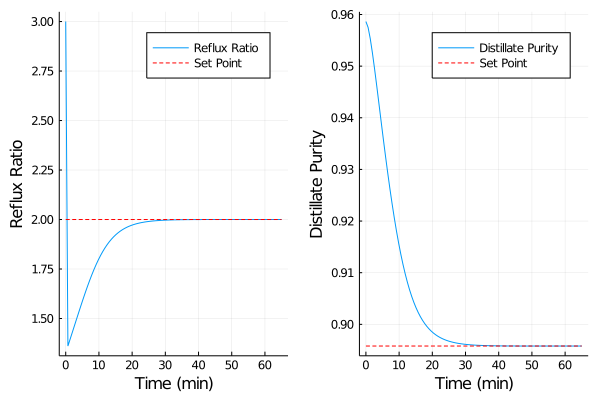

In [12]:
# Extract the results
time_plot = supports(t)
u_plot = value(u)
y_d = value(y_A[1])

# Create set point vectors
time_set = 0:1:65
u_set = ones(size(time_set)) * u_bar
y_set = ones(size(time_set)) * y_bar

# Plot the results
p_1 = plot(time_plot, u_plot, xaxis = "Time (min)", yaxis = "Reflux Ratio", labels = "Reflux Ratio");
p_1 = plot!(time_set, u_set, color = :red, label = "Set Point", line = :dash);
p_2 = plot(time_plot, y_d, xaxis = "Time (min)", yaxis = "Distillate Purity", labels = "Distillate Purity");
p_2 = plot!(time_set, y_set, color = :red, label = "Set Point", line = :dash);
plot(p_1, p_2)